C:\w\1\s\tmp_conda_3.7_100118\conda\conda-bld\pytorch_1579082551706\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.


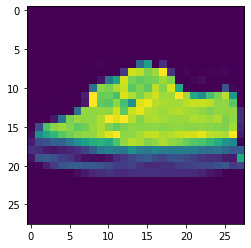

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torchvision import datasets


train_data = datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

valid_data = datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
                   
train_idx = np.random.choice(train_data.train_data.shape[0], 54000, replace=False)
train_data.data = train_data.data[train_idx, :]
train_data.targets = train_data.targets[torch.from_numpy(train_idx).type(torch.LongTensor)]
mask = np.ones(60000)
mask[train_idx] = 0
valid_data.data = valid_data.data[torch.from_numpy(np.argwhere(mask)), :].squeeze()
valid_data.targets = valid_data.targets[torch.from_numpy(mask).type(torch.ByteTensor)]
batch_size = 100
test_batch_size = 100

train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=batch_size, shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_data,
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)
plt.imshow(train_loader.dataset.train_data[1].numpy())

In [46]:
class FcNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 = nn.Linear(300, 10)

    def forward(self, image):
        batch_size = image.size()[0]
        x = image.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [47]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)  # calls the forward function
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
    return model


def valid(model, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        valid_loss += F.nll_loss(output, target, size_average=False).data # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    valid_loss /= len(valid_loader.dataset)
    # print('\n' + "valid" + ' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #     valid_loss, correct, len(valid_loader.dataset),
    #     100. * correct / len(valid_loader.dataset)))
    return valid_loss, 1. * correct / len(valid_loader.dataset)


def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    # print('\n' + "test" + ' set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #     test_loss, correct, len(test_loader.dataset),
    #     100. * correct / len(test_loader.dataset)))
    return test_loss, 1. * correct / len(test_loader.dataset)

def experiment(model, epochs=50, lr=0.001):
    best_model = model
    best_accuracy = 0
    optimizer = optim.SGD(model.parameters(), lr=lr)
    for epoch in range(1, epochs + 1):
        model = train(model, train_loader, optimizer)
        valid_loss, accuracy = valid(model, valid_loader)
        losses.append(valid_loss)
        accuracies.append(accuracy)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
    return best_model, best_accuracy


In [48]:
losses = []
accuracies = []
best_model = None
best_accuracy = 0

for model in [FcNetwork()]:  # add your models in the list
    model, accuracy = experiment(model)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

test(best_model, test_loader)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



valid set: Average loss: 1.7044, Accuracy: 3701/6000 (62%)


valid set: Average loss: 1.2081, Accuracy: 3912/6000 (65%)


valid set: Average loss: 0.9711, Accuracy: 4033/6000 (67%)


valid set: Average loss: 0.8529, Accuracy: 4230/6000 (70%)


valid set: Average loss: 0.7817, Accuracy: 4403/6000 (73%)


valid set: Average loss: 0.7281, Accuracy: 4532/6000 (76%)


valid set: Average loss: 0.6870, Accuracy: 4641/6000 (77%)


valid set: Average loss: 0.6537, Accuracy: 4692/6000 (78%)


valid set: Average loss: 0.6243, Accuracy: 4775/6000 (80%)


valid set: Average loss: 0.6011, Accuracy: 4800/6000 (80%)


valid set: Average loss: 0.5811, Accuracy: 4823/6000 (80%)


valid set: Average loss: 0.5657, Accuracy: 4840/6000 (81%)


valid set: Average loss: 0.5507, Accuracy: 4876/6000 (81%)


valid set: Average loss: 0.5392, Accuracy: 4875/6000 (81%)


valid set: Average loss: 0.5287, Accuracy: 4905/6000 (82%)


valid set: Average loss: 0.5205, Accuracy: 4910/6000 (82%)


valid set: Average loss